# Serielle Daten Anfordern und in einer CSV-Datei speichern

Dies Notebook verbindet sich selbständig mit einem Arduino Uno und fordert Daten an.

https://be189.github.io/lessons/00/configuring_your_computer.html

In [1]:
import time

import numpy as np
import pandas as pd
import csv  
import serial
import serial.tools.list_ports

from IPython.display import clear_output
from matplotlib import pyplot as plt

## Parameters 





In [14]:
HANDSHAKE = 0
VOLTAGE_REQUEST = 1

# Parameter können geändert werden
SAMPLE_TIME = .2
DATA_POINTS = 100

print("time to finish: "+str(SAMPLE_TIME*DATA_POINTS)+"s")

CSVfileName = "data.csv"
PLOTfileName = "data.png"

# Ausgleichsgerade 
fitLine = True

time to finish: 20.0s


In [3]:
def find_arduino(port=None):
    """Get the name of the port that is connected to Arduino."""
    if port is None:
        ports = serial.tools.list_ports.comports()
        for p in ports:
            if p.manufacturer is not None and "Arduino" in p.manufacturer:
                port = p.device
    return port

def handshake_arduino(
    arduino, sleep_time=1, print_handshake_message=False, handshake_code=0
):
    """Make sure connection is established by sending
    and receiving bytes."""
    # Close and reopen
    arduino.close()
    arduino.open()

    # Chill out while everything gets set
    time.sleep(sleep_time)

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()

    # Send request to Arduino
    arduino.write(bytes([handshake_code]))

    # Read in what Arduino sent
    handshake_message = arduino.read_until()

    # Send and receive request again
    arduino.write(bytes([handshake_code]))
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout

## Serielle Verbindung zum Arduino aufbauen und testen 

In [4]:
port = find_arduino()
arduino = serial.Serial(port, baudrate=115200)
handshake_arduino(arduino, handshake_code=HANDSHAKE, print_handshake_message=True)

Handshake message: Message received.



In [5]:
def parse_raw(raw):
    """Parse bytes output from Arduino."""
    raw = raw.decode()
    if raw[-1] != "\n":
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )

    t, V = raw.rstrip().split(",")

    return int(t), int(V)

In [6]:
def request_single_datapoint(arduino):
    """Ask Arduino for a single data point from analogRead [0,1023]"""
    # Ask Arduino for data
    arduino.write(bytes([VOLTAGE_REQUEST]))

    # Read in the data
    raw = arduino.read_until()

    # Parse and return
    return parse_raw(raw)

In [7]:
request_single_datapoint(arduino)

(12279194, 93)

In [15]:
def live_plot(x, y,save=False, fitLine= False, figsize=(10,5), title='SensorData'):
    """Plot Data in real time"""
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    
    ylimMin = max(min(y) - .2,0)
    ylimMax = max(y) + .2
    plt.ylim(ylimMin, ylimMax)
    
    x = [float(i) for i in x]
    y = [float(i) for i in y]
    
    if len(x) > 1:
        plt.scatter(x,y, label='axis y', color='k') 
        if fitLine:
            m, b = np.polyfit(x, y, 1)
            plt.plot(x, [x * m for x in x] + b)
            
    plt.title(title)
    plt.grid(True)
    plt.xlabel('time (s)')
    plt.ylabel('senValue (V)')
    
    if save:
        plt.savefig(PLOTfileName)
        print("Figure saved in File: " + PLOTfileName)
    plt.show()

Figure saved in File: data.png


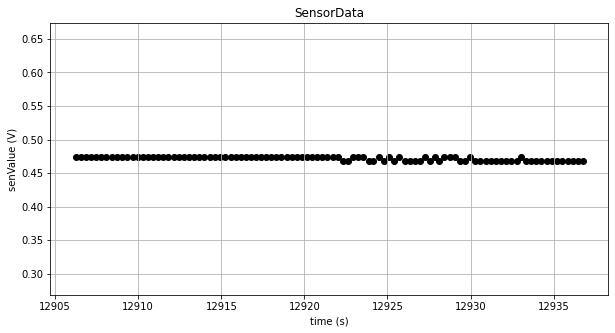

In [16]:
x = []
y = []

header = ['time', 'data']

string = str(DATA_POINTS*SAMPLE_TIME)+"s to finish! Press Enter."
input(string)


with open(CSVfileName, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    
for i in range(DATA_POINTS):
    # Request and append
    t, V = request_single_datapoint(arduino)
    
    x.append(t/1000)
    y.append(V/1024*5)
    
    live_plot(x,y,False,fitLine)
    
    data = pd.DataFrame([(int(t/1000),V/1024*5)])
    
    data.to_csv("data.csv",index=False,header=False,mode="a")    
    
    time.sleep(SAMPLE_TIME)

live_plot(x,y,True)